In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
from shapely.geometry import LineString, Point
import networkx as nx
import folium
import time
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
from dijkstra_path_prediction import DijkstraPathPrediction
import prediction_model_evaluation_metrics as metrics

In [3]:
# Load a model from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_date = '202205'
test_date = '202206'
DP_tol = 10
min_samples = 13

model_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model_name + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [4]:
# Load training data from file
filename = model_name+'_'+train_date+'_paths.csv'
training_data = pd.read_csv('../../data/paths/'+filename)
training_data['path'] = training_data['path'].apply(literal_eval)
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.GeoSeries.from_wkt(training_data['geometry']), crs=network.crs)
training_data = training_data[training_data['message']=='success']

In [5]:
# Load test data from file
filename = model_name+'_'+test_date+'_paths.csv'
test_data = pd.read_csv('../../data/paths/'+filename)
test_data['path'] = test_data['path'].apply(literal_eval)
test_data = gpd.GeoDataFrame(test_data, geometry=gpd.GeoSeries.from_wkt(test_data['geometry']), crs=network.crs)
test_data = test_data[test_data['message']=='success']

# Load respective trajectories for evaluation
traj_file = test_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + traj_file + '.parquet'
traj_gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
traj_gdf.to_crs(crs, inplace=True)  # Transformation
test_trajectories = mpd.TrajectoryCollection(traj_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

In [6]:
training_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1433 entries, 0 to 1451
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Unnamed: 0        1433 non-null   int64   
 1   mmsi              1433 non-null   object  
 2   SSPD              1433 non-null   float64 
 3   distances         1433 non-null   object  
 4   fraction_covered  1433 non-null   float64 
 5   message           1433 non-null   object  
 6   path              1433 non-null   object  
 7   path_linestring   1433 non-null   object  
 8   lengde            1433 non-null   int64   
 9   bredde            1039 non-null   float64 
 10  dypgaaende        942 non-null    float64 
 11  skipstype         1039 non-null   object  
 12  skipsgruppe       1039 non-null   object  
 13  geometry          1433 non-null   geometry
dtypes: float64(4), geometry(1), int64(2), object(7)
memory usage: 167.9+ KB


In [7]:
# train model
model = DijkstraPathPrediction()
model.train(network.G_pruned, training_data['path'])

Evaluating Dijkstra model on 761 samples for path prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 28374336.67 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 203.99m
Median SSPD: 43.42m
Mean choice_accuracy: 0.6824


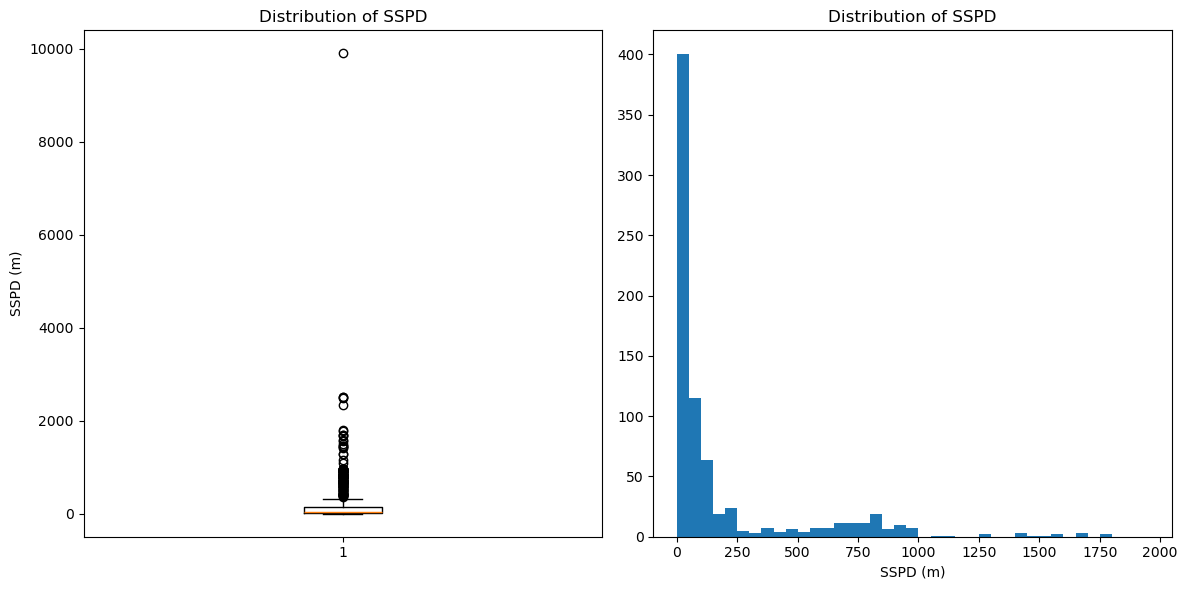

In [8]:
# evaluate model
selection = range(0, len(test_data), 2)  # len(test_data)
test_paths = test_data.iloc[selection]
eval_results, fig = metrics.evaluate(model, 'path', test_paths, test_trajectories, network, eval_mode='path')

In [9]:
eval_results

mmsi  \
0    210055000_0_2022-06-01 09:31:46   
0    210189000_0_2022-06-24 06:55:42   
0    210189000_8_2022-06-25 16:12:16   
0    211102000_0_2022-06-03 02:00:05   
0    211102000_6_2022-06-03 20:10:17   
..                               ...   
0    314259000_1_2022-06-01 06:38:00   
0   314318000_10_2022-06-09 02:16:34   
0    314318000_6_2022-06-08 18:01:01   
0    314631000_0_2022-06-09 14:42:08   
0   319139200_30_2022-06-11 16:52:42   

                                            true_path  \
0   [130, 129, 128, 4, 350, 349, 323, 309, 455, 45...   
0   [185, 180, 179, 178, 224, 223, 204, 217, 247, ...   
0                       [458, 467, 466, 463, 462, 25]   
0       [366, 352, 359, 374, 384, 375, 380, 364, 468]   
0                                          [465, 464]   
..                                                ...   
0   [184, 180, 179, 178, 224, 223, 236, 155, 401, ...   
0   [476, 490, 504, 505, 502, 503, 484, 485, 486, ...   
0   [365, 358, 357, 355, 360, 320, 327, 329, 336, ...   
0   [185, 180, 179, 178, 224, 223, 236, 217, 247, ...   
0                                          [173, 171]   

                                       predicted_path  \
0   [130, 129, 128, 4, 354, 353, 350, 349, 323, 31...   
0   [185, 180, 179, 178, 224, 223, 236, 217, 247, ...   
0                       [458, 467, 466, 463, 462, 25]   
0   [366, 365, 358, 357, 361, 352, 359, 374, 384, ...   
0                                          [465, 464]   
..                                                ...   
0   [184, 180, 179, 178, 224, 223, 236, 217, 247, ...   
0   [476, 490, 504, 505, 502, 503, 484, 485, 486, ...   
0   [365, 358, 357, 361, 352, 359, 374, 384, 375, ...   
0   [185, 180, 179, 178, 224, 223, 236, 217, 247, ...   
0                                          [173, 171]   

                                            distances          SSPD  \
0   [0.0, 5.411314500018318e-12, 6.908473696990645...  8.538437e+02   
0   [0.0, 2.5723016972688495e-10, 3.08233689958954...  1.406577e+02   
0   [0.0, 1.5350618722525568e-10, 1.84962196370548...  7.036974e-11   
0   [0.0, 135.3060553449902, 270.6121106899804, 32...  6.757185e+01   
0   [0.0, 8.961318150483569e-11, 8.050456454975777...  1.237946e-10   
..                                                ...           ...   
0   [0.0, 2.59047194123822e-10, 2.4329177490409683...  2.596479e+02   
0   [0.0, 1.0345357902444548e-10, 4.65495924785292...  3.704646e+01   
0   [0.0, 1.7312280879839838e-10, 3.46245617596796...  6.965749e+02   
0   [0.0, 1.548797996575935e-10, 1.261339965269736...  7.347433e+02   
0   [0.0, 1.850743590429422e-10, 2.893681630667283...  1.679174e-10   

    choice_accuracy  
0          0.440678  
0          0.743590  
0          1.000000  
0          0.625000  
0          1.000000  
..              ...  
0          0.538462  
0          0.755102  
0          0.200000  
0          0.508197  
0          1.000000  

[761 rows x 6 columns]

In [10]:
'''
# plot prediction results
index = 0  # which prediction to plot
mmsi = eval_results['mmsi'].iloc[index]
prediction = eval_results['predicted_path'].iloc[index][1:]
predictions = {tuple(prediction):1}
true_path = eval_results['true_path'].iloc[index]
start_node = true_path[0]
start_node = [start_node]
end_node = true_path[-1]
trajectory = test_trajectories.get_trajectory(mmsi)

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, min_passages=1, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+model_name+'_dijkstra_predictions.html')
print(f'Map saved under {"../../reports/maps/"+model_name+"_dijkstra_predictions.html"}')
'''

'\n# plot prediction results\nindex = 0  # which prediction to plot\nmmsi = eval_results[\'mmsi\'].iloc[index]\nprediction = eval_results[\'predicted_path\'].iloc[index][1:]\npredictions = {tuple(prediction):1}\ntrue_path = eval_results[\'true_path\'].iloc[index]\nstart_node = true_path[0]\nstart_node = [start_node]\nend_node = true_path[-1]\ntrajectory = test_trajectories.get_trajectory(mmsi)\n\nmap = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, min_passages=1, opacity=0.2, location=location, end_node=end_node)\nmap.save(\'../../reports/maps/\'+model_name+\'_dijkstra_predictions.html\')\nprint(f\'Map saved under {"../../reports/maps/"+model_name+"_dijkstra_predictions.html"}\')\n'

In [21]:
# make predictions with the Dijkstra model
example = test_data.iloc[1]
mmsi = example.mmsi
start_node = [example.path[0]]
end_node = example.path[-1]
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

predictions = model.predict(start_node[-1], end_node)
predictions = {tuple(predictions[len(start_node):]):'1.0'}

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+model_name+'_dijkstra_predictions.html')
print(f'Map saved under {"../../reports/maps/"+model_name+"_dijkstra_predictions.html"}')

Map saved under ../../reports/maps/202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM_dijkstra_predictions.html
